<a href="https://colab.research.google.com/github/gachet/ad-1-24/blob/main/LOG/multiclass_logistic_regression_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

import warnings
warnings.filterwarnings('ignore')

# Multiclass multivariable logistic regression

This notebook should sere as a guide in how to implement multiclass logistic regression for simple systems so that you can scale this up for your problems. (Note: much of what has been coded explicitly for the three categories would likely need to be changed to a loop for large number of features. I have not in this notebook in order to make it as clear as possible what is going on).

There is an explanation of the mathematics behind logistic regression for a binary classification problem in here but it is not in as much detail as my other [notebook on logistic regression for binary classification](https://www.kaggle.com/kieranfox/logistic-regression-tutorial-from-scratch-in-py). Please see this guide for a more detailed explanation and instructions on how to implement it in python.

Here we use the sklearn function 'make_blobs' to generate data with a number of categories so we can test multiclass regression.

   bias     feat1     feat2
0     1  4.666472  0.504177
1     1  4.902562 -1.087954
2     1  6.918273 -8.575283
3     1  7.690139 -7.518141
4     1  2.773908 -0.823905
   label
0      2
1      0
2      1
3      1
4      0


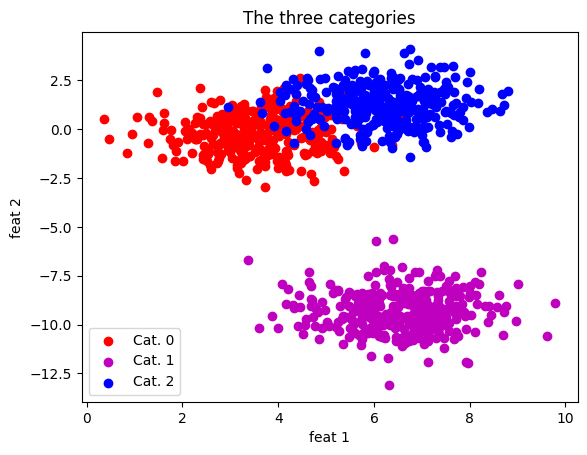

In [2]:
instances = 1000
groups = 3
features = 2

# Randomly generates multicategory data for classification
# random state ensures same data each time so we can compare runs
X, y = make_blobs(n_samples=instances, centers=groups, n_features=features, random_state=99)

# Extractin the input information and putting it into a dataframe for manipulations
df_X = pd.DataFrame()
df_X['bias'] = [1]*instances
df_X['feat1'] = X[:,0]
df_X['feat2'] = X[:,1]
print(df_X.head())

# bringing the y values into a dataframe for manipulations
df_y = pd.DataFrame()
df_y['label'] = y
print(df_y.head())

# PLotting the three groups according to the two features
plt.scatter(df_X.loc[df_y['label'] == 0, 'feat1'], df_X.loc[df_y['label'] == 0, 'feat2'],
            c='r', label = 'Cat. 0')
plt.scatter(df_X.loc[df_y['label'] == 1, 'feat1'], df_X.loc[df_y['label'] == 1, 'feat2'],
            c='m', label = 'Cat. 1')
plt.scatter(df_X.loc[df_y['label'] == 2, 'feat1'], df_X.loc[df_y['label'] == 2, 'feat2'],
            c='b', label = 'Cat. 2')
plt.title('The three categories')
plt.xlabel('feat 1')
plt.ylabel('feat 2')
plt.legend()
plt.show()

We have used only two features in order to be able to visualise the data and the decision boundaries we will calculate. However, this can be used for any number of variables and only in the extremely large cases ($> 10^{5}$) would we need to use more sophisticated algorithms to help convergence.

The data is divided into three categories. We can see substantial overlap between categories 0 and 2 which will undoubtedly cause some errors in our final model as there are plenty of data points that could easily be in either category. We can see that it would be impossible to split all three categories with a straight line. A split down the middle of category 0 and 2 would no exclude points from category 2. We will therefore need to use polynomial terms. However, it is a relatively simple spread so we will avoid overfitting by only using feat$^{2}$ terms.

We have included the bias as a pseudo feature with all its values set to 1. This means that the weighting will be added to every single instance and so will act as a bias.

In [3]:
# Splitting the y-values into test and train
df_X_test = df_X[int(instances * 0.8):]
df_X = df_X[:int(instances * 0.8)]

# Creating the dummy variables. Ie chaging the three category label to three binary categories
dummies = pd.get_dummies(df_y['label'])
df_y = pd.concat((df_y, dummies), axis = 1)

# Splitting the y-values into test and train
df_y_test = df_y[int(instances * 0.8):]
df_y = df_y[:int(instances * 0.8)]

print(df_y.head())

   label      0      1      2
0      2  False  False   True
1      0   True  False  False
2      1  False   True  False
3      1  False   True  False
4      0   True  False  False


We split our data into train and test. We will now continue with the train data and go back to the test data when we have made our model.

We have converted our three category target label from $y \in \{0,1,3\}$ to label_0 $\in \{0,1\}$, label_1 $\in \{0,1\}$ and label_2 $\in \{0,1\}$. This turns out multiclass classification into three binary classification problems. From here we can just implement usual logistic regression three times to gain a probability of each instance being in category 0, category 1 and category 2.

In [4]:
# The fucntion we get our probability of yes or no (0 or 1)
def log_func(X, theta):
    return 1/(1+np.exp(-np.matmul(X, theta)))

# The quantification of how good our parameters are
def cost_func(X, y, theta):
    mm = len(X)
    return (-1/mm) * np.sum((y * np.log(log_func(X, theta))) + ((1-y) * (np.log(1-log_func(X, theta)))))

# Adjusts the weights according to the partial derivatives of the cost function
def gradient_descent(X, y, theta, alpha):
    mm = len(y)
    return theta - ((alpha*mm)*np.matmul(np.transpose(X), (log_func(X, theta))-y))

The log function takes in input data of our features and weights with which to scale our features, and outputs a probability $P(y=1)$ from 0 to 1. This can be used for each instance to give a probability of each category.

The cost function gives us an indication of how good our parameters are at predicting the right categories. If our probability value is far from the actual value of 0 or 1, we get a large cost and vice versa. Minimizing this ensures we get a good fit to our target values.

The gradient descent is the partial derivative of the cost function. The slope of the cost function for each parameter indivdually tells us how to alter that particular parameter in order to reduce the cost function. We control the descent with the learning rate ($\alpha$) so that we dont overshoot the minimum and increase up the other side of the cost function slope.

In [5]:
# Feature scaling to aid convergence
df_X['feat1'] = df_X['feat1'] / (df_X['feat1'].max() - df_X['feat1'].min())
df_X['feat2'] = df_X['feat2'] / (df_X['feat2'].max() - df_X['feat2'].min())

# Adding polynomial terms as there are groups which are not so easily split by linear
df_X['feat1^2'] = df_X['feat1'] ** 2
df_X['feat2^2'] = df_X['feat2'] ** 2

print(df_X.head())

# Obtaining our feature inputs (same as before)
X = df_X.values
# Our optimization parameter
alpha = 1e-6
# The number of loops we are using to converge
loops = 100000

   bias     feat1     feat2   feat1^2   feat2^2
0     1  0.504564  0.029448  0.254585  0.000867
1     1  0.530091 -0.063546  0.280997  0.004038
2     1  0.748041 -0.500872  0.559565  0.250873
3     1  0.831499 -0.439126  0.691391  0.192832
4     1  0.299930 -0.048123  0.089958  0.002316


Here we have scaled down our features to be between -1 and 1. This will aid gradient descent as no particular parameter will have a much large gradient than another. They are then squared to give us our polynomial terms. We can make a linear relationship of the feature squared to give non-linear shape to the decision boundary.

We then set our alpha value as the highest in can be while still maintaining consistent decline of the cost function. This has been altered after checking the cost function plot.

Category 0

Initial parameters are [1 1 0 1 0]
Final parameters are [  8.47849902  -9.32502154 -14.74472811 -10.50578267 -51.37585359]


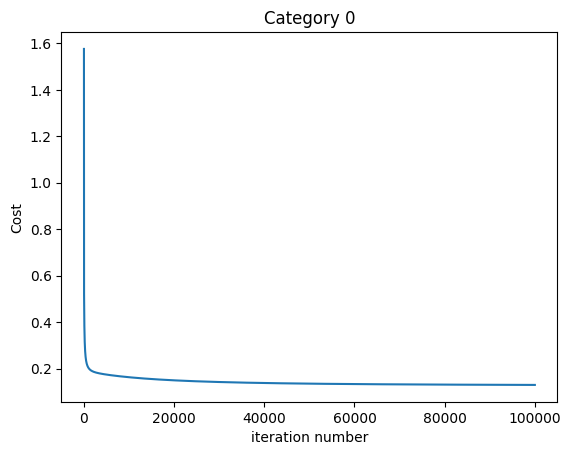

Category 1

Initial parameters are [1 0 1 0 1]
Final parameters are [-10.58608491   1.50172743 -26.89576652   4.33175963  13.93086057]


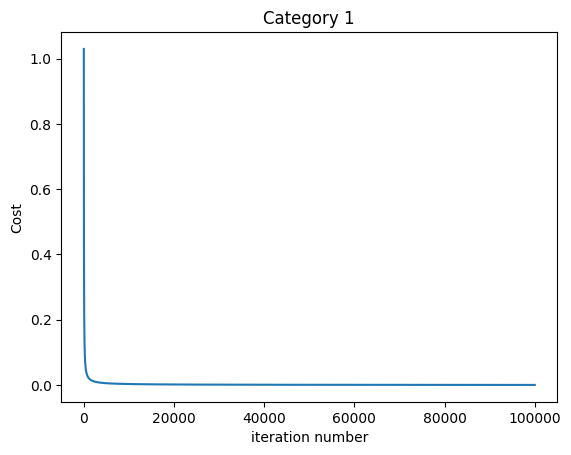

Category 2

Initial parameters are [0 1 0 0 1]
Final parameters are [-9.65899951 12.31675546 25.46390302  8.64979633 -7.91298121]


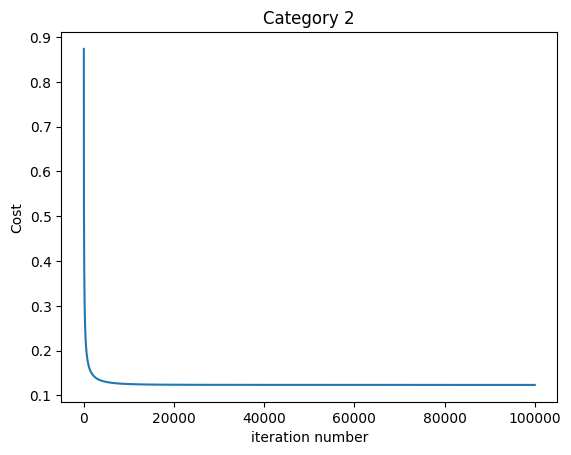

In [6]:
# Loops the parameter update over and over to get the best possible parameters
def get_params(target, alpha, loops):
    y = df_y[target].values
    # Our inital guess of the parameters, this time in vector form
    theta = np.random.randint(0, 2, X.shape[1])

    print(f'Initial parameters are {theta}')

    # This will be used to track the cost over the iterations to check it is decreasing
    cost_tracker = []
    for ii in range(loops):
        cost_tracker.append(cost_func(X, y, theta))
        theta = gradient_descent(X, y, theta, alpha)

    print(f'Final parameters are {theta}')

    #PLotting the cost as a function of its the iteration number
    plt.plot(cost_tracker)
    plt.xlabel('iteration number')
    plt.ylabel('Cost')
    plt.title(f'Category {target}')
    plt.show()

    return theta

print('Category 0\n')
theta_0 = get_params(0, alpha, loops)
print('Category 1\n')
theta_1 = get_params(1, alpha, loops)
print('Category 2\n')
theta_2 = get_params(2, alpha, loops)

Here we see our inital value for the weighting parameters changed to more accurately fit the data. The cost function decreases consistently for all three categories. We see a slightly slower descent for category 0 suggesting a more complicated shape. Finally we see that the lowest final cost is for category 1 which is expected as this is the only category with no overlap with another category.

In [7]:
# Finding the value of the logistic function for a single pair of values of the features
def find_probability(weights, x1, x2):
    return weights[0] + weights[1]*x1 + weights[2]*x2 + weights[3]*x1*x1 + weights[4]*x2*x2

# Finds the probability of being a certain category for many points
def find_grid(grid, weights):
    prob = []
    for row in grid:
        prob.append(1/(1+np.exp(-find_probability(weights, row[0], row[1]))))
    return np.array(prob)

# Creating the 2d area we will plot our decision line in
x1 = np.linspace(0, 1.1, 10)
x2 = np.linspace(-1.0, 0.5, 10)
ax1, ax2 = np.meshgrid(x1,x2)
grid = np.c_[ax1.ravel(), ax2.ravel()]

Find probability gives us the probability of being a certain category for a certain combination of feature values. The weights we input determine which category we are looking for. Find grid then uses this function to find the values of a 2d array of feature combinations. This will be used for plotting the decision boundary.

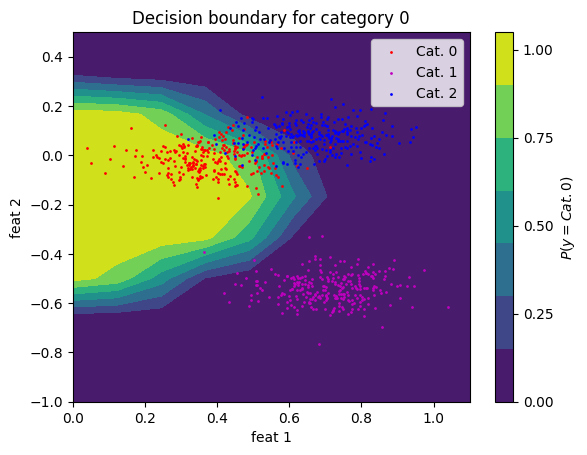

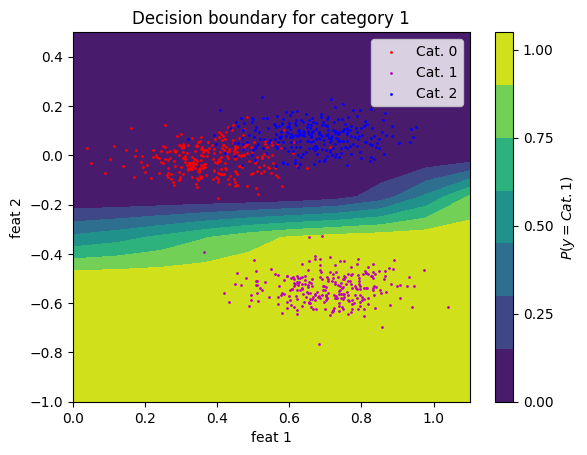

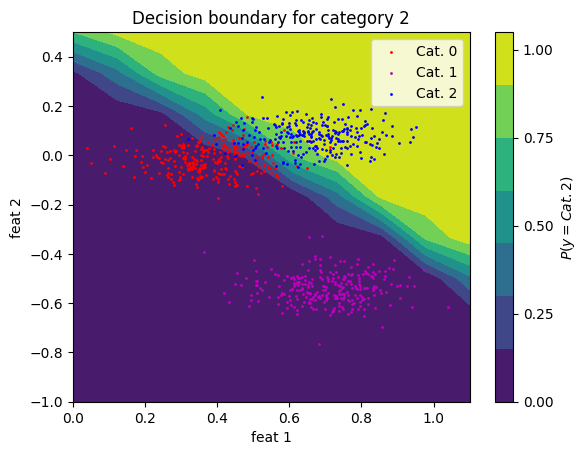

In [8]:
# PLots out probabilities in 2d space in order to visialise them
def plot_prob_grid(theta, name='Category'):
    # gets the probability array
    prob_grid = find_grid(grid, theta).reshape(10,10)

    fig, ax = plt.subplots(dpi = 100)

    # Plots the probabilities as a contour plot
    contour = ax.contourf(ax1, ax2, prob_grid)
    ax_c = fig.colorbar(contour)
    ax_c.set_label(f"$P(y = Cat. {name})$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax = plt.scatter(df_X.loc[df_y['label'] == 0, 'feat1'], df_X.loc[df_y['label'] == 0, 'feat2'],
                c='r', label = 'Cat. 0', s=1)
    ax = plt.scatter(df_X.loc[df_y['label'] == 1, 'feat1'], df_X.loc[df_y['label'] == 1, 'feat2'],
                c='m', label = 'Cat. 1', s=1)
    ax = plt.scatter(df_X.loc[df_y['label'] == 2, 'feat1'], df_X.loc[df_y['label'] == 2, 'feat2'],
                c='b', label = 'Cat. 2', s=1)
    plt.title(f'Decision boundary for category {name}')
    plt.xlabel('feat 1')
    plt.ylabel('feat 2')
    plt.legend()

    plt.show()

plot_prob_grid(theta_0, name = '0')
plot_prob_grid(theta_1, name = '1')
plot_prob_grid(theta_2, name = '2')

Here we see the probability arrays. yellow is a high probability of being a certain category and blue is low. The line between them at $P(y=1) = 0.5$ is called the decision boundary.

We can see a clear and consistnet divide between category 1 and not category 1. However, the decision boundary between category 0 and 2 shows many data points with a higher probability of the wrong category assignment. This was inevitable however given our features and in a real life system we would need more features to split these two more accurately.

In [9]:
# Calculating the probability of each category for all the points in our train
df_y['prob_0'] = log_func(X, theta_0)
df_y['prob_1'] = log_func(X, theta_1)
df_y['prob_2'] = log_func(X, theta_2)

# Fidning the highest value of our probabilites
df_y['Pred_label'] = df_y[['prob_0','prob_1', 'prob_2']].idxmax(axis=1)
df_y['Pred_label'] = df_y['Pred_label'].replace({"prob_0": 0,
                                                 "prob_1": 1,
                                                 "prob_2": 2})

print(df_y.head())
print('\nPearson R correlation - ', df_y['label'].corr(df_y['Pred_label']))

   label      0      1      2    prob_0    prob_1    prob_2  Pred_label
0      2  False  False   True  0.650230  0.000074  0.377708           0
1      0   True  False  False  0.787981  0.001104  0.087105           0
2      1  False   True  False  0.000051  0.999951  0.000032           1
3      1  False   True  False  0.000047  0.999713  0.002140           1
4      0   True  False  False  0.995166  0.000220  0.001609           0

Pearson R correlation -  0.8442921422571852


We calculate theprobablity of each instance being each category and then take the highest probability as being most likely to be the target. Our correlation shows that our odel fits the data well but is not perfect. This is becasue of the overlap between categories 0 and 2.

In [10]:
print(df_X_test.head())
# Feature scaling for the test values
df_X_test['feat1'] = df_X_test['feat1'] / (df_X_test['feat1'].max() - df_X_test['feat1'].min())
df_X_test['feat2'] = df_X_test['feat2'] / (df_X_test['feat2'].max() - df_X_test['feat2'].min())

# Getting the polynomial terms for the test
df_X_test['feat1^2'] = df_X_test['feat1'] ** 2
df_X_test['feat2^2'] = df_X_test['feat2'] ** 2

# Extracting the input data to calculate probabilities from
X_test = df_X_test.values

# Calculating probabilities of each category using the parameters we calculated earlier
df_y_test['prob_0'] = log_func(X_test, theta_0)
df_y_test['prob_1'] = log_func(X_test, theta_1)
df_y_test['prob_2'] = log_func(X_test, theta_2)

# Fidning the highest value of our probabilites
df_y_test['Pred_label'] = df_y_test[['prob_0','prob_1', 'prob_2']].idxmax(axis=1)
df_y_test['Pred_label'] = df_y_test['Pred_label'].replace({"prob_0": 0,
                                                 "prob_1": 1,
                                                 "prob_2": 2})

print(df_y_test.head())
print('\nPearson R correlation - ', df_y_test['label'].corr(df_y_test['Pred_label']))

     bias     feat1     feat2
800     1  6.112233  1.684590
801     1  5.486594 -9.045249
802     1  6.357864 -9.366972
803     1  6.395830  0.186945
804     1  4.644804 -7.809590
     label      0      1      2    prob_0    prob_1        prob_2  Pred_label
800      2  False  False   True  0.002970  0.000049  9.981671e-01           2
801      1  False   True  False  0.000049  0.999992  3.385714e-07           1
802      1  False   True  False  0.000002  0.999998  2.083256e-06           1
803      2  False  False   True  0.008875  0.000676  9.922509e-01           2
804      1  False   True  False  0.008595  0.999627  4.783800e-07           1

Pearson R correlation -  0.8794080883518105


We now do the same process with our test data. This means scaling the features and creating new polynomial features. This was done separately with the training data set to avoid any information from the test set being included in the training. The new input parameters are extracted and are used with our trained parameters to give probabilites for each instance.

The final correlation is actually higher than for the training dataset. This is pretty unusual but is likely just that the test dataset happened to be a bit neater with a little less overlap.